<a href="https://colab.research.google.com/github/VolkhinD/Steel/blob/main/Ultralytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install ultralytics
!pip install PyYAML

In [68]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow # since cv2.imshow collaps Colab session
from sklearn.model_selection import GroupShuffleSplit
import torch
import seaborn as sns

import os
import shutil
import yaml

sns.set_palette('BrBG_r')

In [4]:
IMG_SIZE = (256, 1600)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Play with YOLO

In [82]:
img1 = '/content/drive/MyDrive/Data/IMG_1541.jpg'
img2 = '/content/drive/MyDrive/Data/IMG_1476.jpg'
img3 = '/content/pr_cat.jpg'
im1 = cv2.imread(img1)

In [86]:
seg_model = YOLO('yolov8m-seg.pt')

In [87]:
results = seg_model.predict(im1)
result = results[0]
masks = result.masks
len(masks)


0: 640x480 1 cat, 1 refrigerator, 44.7ms
Speed: 3.4ms preprocess, 44.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 480)


2

In [90]:
mask1 = masks[0].data.cpu()
mask2 = masks[1].data.cpu()

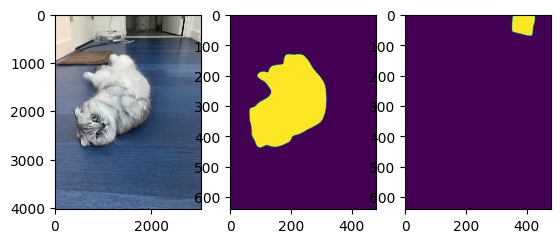

In [91]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(im1)
ax[1].imshow(mask1.permute(1, 2, 0))
ax[2].imshow(mask2.permute(1, 2, 0))

# Create masks and polygons

In [12]:
data = pd.read_csv('/content/drive/MyDrive/Data/Steel/train.csv')


In [13]:
data.ClassId = data.ClassId.map({1: 0, 2: 1, 3: 2, 4: 3})
data.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,0,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,2,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,0,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,3,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,2,229501 11 229741 33 229981 55 230221 77 230468...


In [16]:
def rle_2D_mask(idx, imgshape=IMG_SIZE):

  """Creates mask for all types of defects"""

  width = imgshape[0]
  height= imgshape[1]
  img_name = data.iloc[idx].ImageId
  all_img = data.groupby('ImageId').get_group(img_name)

  mask = np.zeros(width*height).astype(np.uint8)

  if all_img.EncodedPixels.isnull().any(): # any because I plan to add img with no defects so they have only 'ImageId'
    return mask.reshape(width, height)

  for class_id, rle in zip(all_img.ClassId.to_numpy(), all_img.EncodedPixels.to_numpy()):
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = class_id


  return np.flipud(np.rot90(mask.reshape(height, width), k=1))

In [17]:
""" Copied from Kaggle"""
def rle2mask(rle, imgshape=IMG_SIZE):

  """ Creates mask for only one type of deffect """

  width = imgshape[0]
  height= imgshape[1]

  mask = np.zeros( width*height ).astype(np.uint8)

  array = np.asarray([int(x) for x in rle.split()])
  starts = array[0::2]
  lengths = array[1::2]

  for index, start in enumerate(starts):
      mask[int(start):int(start+lengths[index])] = 1


  return np.flipud(np.rot90( mask.reshape(height, width), k=1))

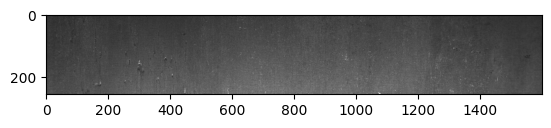

In [9]:
path = '/content/drive/MyDrive/Data/Steel/data/train/images/'
fn = data['ImageId'].iloc[2]
img = cv2.imread(path + fn)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

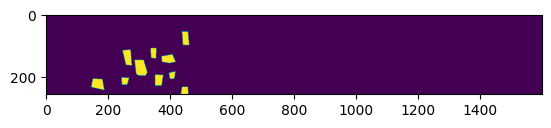

In [10]:
mask1 = rle_2D_mask(2)
plt.imshow(mask1)

## RLE to Polygon

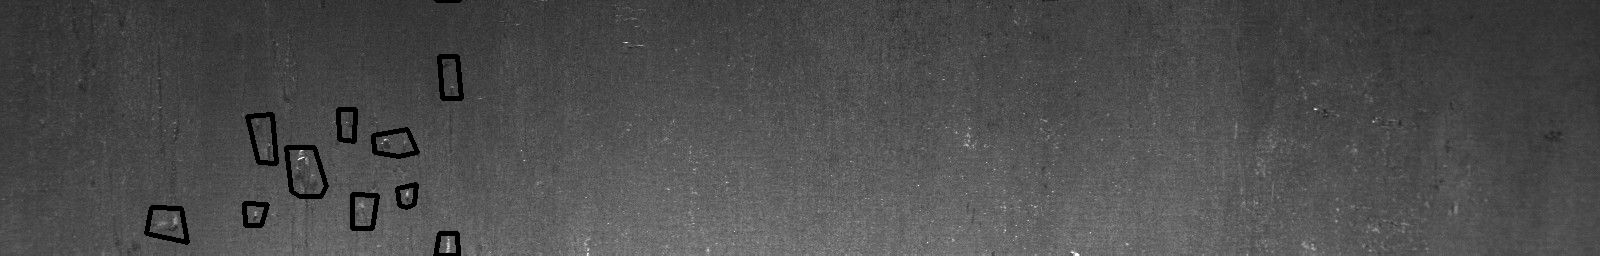

In [22]:
fn = data['ImageId'].iloc[2]
img = cv2.imread(path + fn)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contours, heirarchy = cv2.findContours(mask1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#draw the obtained contour lines(or the set of coordinates forming a line) on the original image
cv2.drawContours(img, contours, -1, (0,255,0), 3)
#show the image
cv2_imshow(img)


In [23]:
print(f"There are {len(contours)} objects on this example mask")
print(f"Image shape {img.shape}")

There are 11 objects on this example mask
Image shape (256, 1600)


In [24]:
# f = open("/content/drive/MyDrive/Data/Steel/data/train/labels/test.txt", "a")
# for i in range(10):
#   f.write(str(i) + '\t')
# f.write('\n')
# f.close()



# Getting Ready Images with [this Artical](https://dev.to/andreygermanov/how-to-implement-instance-segmentation-using-yolov8-neural-network-3if9#get_started)

1. Created a folder for dataset and two subfolders in it: "images" and "labels".

2. Put the images to the "images" subfolder.

3. For each image, create an annotation text file in the "labels" subfolder. Annotation text files should have the same names as image files and the ".txt" extensions. In annotation file you should add records about each object, that exist on the appropriate image in the following format:

    {object_class_id} {polygon}

    **object_class_id** is a label of object class, there are 4 classes in dataset

    **polygon** is a coordinates of bounding polygon for this object in the following format: x1 y1 x2 y2 ...

    Coordinates should be normalized to fit in a range from 0 to 1. To calculate them, I need to use the following formulas:

    x = x/image_width
    y = y/image_height

4. Finally, I need to create a dataset descriptor YAML-file, that points to created datasets and describes the object classes in them.



## Split to Train and Validation

In [18]:
"""Done this ones """

splitter = GroupShuffleSplit(test_size=.15, n_splits=2, random_state = 7)
split = splitter.split(data, groups=data.ImageId)
train_inds, test_inds = next(split)

# train = data.iloc[train_inds]
# test = data.iloc[test_inds]

print(f"Length of train set is {len(train_inds)}")
print(f"Length of test set is {len(test_inds)}")


Length of train set is 6037
Length of test set is 1058


In [19]:
def transfer_to_fol(source, destination, indexes):
  absent_files = []
  for idx in indexes:
    img_name = data.ImageId.iloc[idx]
    src_path = os.path.join(source, img_name)
    dst_path = os.path.join(destination, img_name)
    try:
      shutil.move(src_path, dst_path)
    except:
      absent_files.append(img_name)

  return absent_files

In [20]:
# source = '/content/drive/MyDrive/Data/Steel/all/images'
# destination_train = '/content/drive/MyDrive/Data/Steel/data/train/images'
# destination_val = '/content/drive/MyDrive/Data/Steel/data/val/images'
# train_absent = transfer_to_fol(source, destination_train, train_inds)
# test_absent = transfer_to_fol(source, destination_val, test_inds)

In [21]:
print('Number of absent files in train 371')
print('Number of absent files in test 58')
print(f"Number of Images absent in dataset {len(os.listdir('/content/drive/MyDrive/Data/Steel/all/images'))}")

Number of absent files in train 371
Number of absent files in test 58
Number of Images absent in dataset 5907


## Create Text Files

from documentation:

**Each segmentation label must have a minimum of 3 xy points**

**Labels should start with 0**


In [15]:
def create_txt_file(idx, path):
  img_name = data['ImageId'].iloc[idx]
  img_class = data['ClassId'].iloc[idx]
  rle = data['EncodedPixels'].iloc[idx]
  mask = rle2mask(rle)
  contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  f = open(path + img_name[:-3] + 'txt', "a")
  for pair in contours:
    pair = pair.reshape(-1, 2)
    if len(pair) > 2:
      f.write(str(img_class) + ' ')
      for x, y in pair:
        x, y = x / 1600, y / 256
        f.write(str(x) + ' ' + str(y) + ' ')
      f.write('\n')
  f.write('\n')
  f.close()

In [18]:
train_path = '/content/drive/MyDrive/Data/Steel/data/train/labels/'
val_path = '/content/drive/MyDrive/Data/Steel/data/val/labels/'

# existed_train = set()
# existed_val = set()

# train_all_img = os.listdir('/content/drive/MyDrive/Data/Steel/data/train/images/')
# val_all_img = os.listdir('/content/drive/MyDrive/Data/Steel/data/val/images/')

# for img_name in train_all_img:
#     if img_name not in existed_train:
#         existed_train.add(img_name)
#         for idx in data.groupby(data.ImageId).get_group(img_name).index:
#             create_txt_file(idx, train_path)
# for img_name in val_all_img:
#     if img_name not in existed_val:
#         existed_val.add(img_name)
#         for idx in data.groupby(data.ImageId).get_group(img_name).index:
#             create_txt_file(idx, val_path)

In [19]:
assert len(os.listdir(val_path)) == len(os.listdir('/content/drive/MyDrive/Data/Steel/data/val/images'))
assert len(os.listdir(train_path)) == len(os.listdir('/content/drive/MyDrive/Data/Steel/data/train/images'))

## Create YAML-file

In [7]:
data =  dict(
    train = '/content/drive/MyDrive/Data/Steel/data/train/images',
    val =  '/content/drive/MyDrive/Data/Steel/data/val/images',
    nc = 4,
    names = ['0', '1', '2', '3']
            )
with open('parameters.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

# Model Training

In [8]:
# %load_ext tensorboard
# %tensorboard --logdir path/to/runs

In [20]:
model = YOLO('yolov8m-seg.pt')
model = model.to(DEVICE)

In [21]:
model.train(data='parameters.yaml', epochs=30)

engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=parameters.yaml, epochs=30, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, d

train: Scanning /content/drive/MyDrive/Data/Steel/data/train/labels.cache... 5000 images, 666 backgrounds, 0 corrupt: 100%|██████████| 5666/5666 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Data/Steel/data/val/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:49<00:00, 20.37it/s]


val: New cache created: /content/drive/MyDrive/Data/Steel/data/val/labels.cache
Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      8.29G      1.952      3.003      2.284       1.31          7        640: 100%|██████████| 355/355 [03:42<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


                   all       1000       3014      0.524      0.301      0.236      0.106      0.481      0.237      0.175     0.0637

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.14G      1.927      2.865      1.894       1.31         19        640: 100%|██████████| 355/355 [03:42<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


                   all       1000       3014      0.465      0.249      0.198     0.0872      0.415      0.213      0.158     0.0582

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.48G       1.89      2.805       1.85      1.281         10        640: 100%|██████████| 355/355 [03:42<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


                   all       1000       3014      0.558       0.28      0.271      0.123      0.558       0.24      0.222     0.0815

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30       8.2G      1.849      2.719      1.781      1.264         25        640: 100%|██████████| 355/355 [03:42<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


                   all       1000       3014      0.523      0.312      0.286      0.129      0.298       0.24      0.223     0.0798

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30      8.14G      1.806      2.712      1.745      1.241          4        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


                   all       1000       3014      0.403      0.349      0.312      0.147      0.353      0.302      0.248     0.0935

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30      8.48G      1.766      2.667      1.683      1.209          8        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


                   all       1000       3014      0.415      0.415      0.366      0.166      0.527      0.317      0.288      0.105

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.48G      1.736      2.601      1.654      1.201         17        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


                   all       1000       3014       0.44      0.374      0.353      0.165      0.362      0.322      0.273      0.104

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30      8.25G      1.713      2.577      1.625      1.194          7        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


                   all       1000       3014      0.472      0.365      0.361      0.159      0.368      0.374      0.279      0.103

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.22G      1.695       2.56      1.582      1.186         10        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


                   all       1000       3014      0.496      0.396      0.386      0.178      0.437      0.353       0.33      0.124

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30      8.24G      1.659      2.499      1.528      1.159          9        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


                   all       1000       3014      0.479      0.427       0.41      0.182      0.416      0.387      0.349      0.134

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30      8.52G      1.645      2.506      1.521      1.162         14        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


                   all       1000       3014      0.448      0.408      0.394      0.185      0.366      0.339      0.292      0.103

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30      8.17G      1.626      2.445      1.494       1.15         14        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


                   all       1000       3014      0.427      0.424      0.403      0.186      0.317      0.382      0.304      0.112

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.12G      1.609      2.452      1.485      1.142          9        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


                   all       1000       3014      0.424      0.434      0.382      0.181      0.353      0.361      0.287      0.107

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.12G      1.622      2.436      1.471      1.141         11        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


                   all       1000       3014      0.548      0.451      0.424      0.198      0.477      0.361      0.328      0.127

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30      8.16G      1.599      2.433      1.441      1.133          9        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


                   all       1000       3014      0.539      0.433      0.446      0.218      0.367      0.398      0.351      0.144

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30      8.19G      1.587      2.404      1.431      1.135          7        640: 100%|██████████| 355/355 [03:41<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


                   all       1000       3014      0.543      0.428      0.445      0.207      0.503      0.373      0.366      0.143

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30      8.13G       1.56      2.377      1.404      1.118          7        640: 100%|██████████| 355/355 [03:41<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


                   all       1000       3014      0.529      0.478      0.493      0.228      0.421      0.405      0.368      0.148

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30      8.21G      1.568      2.367      1.389      1.119         11        640: 100%|██████████| 355/355 [03:41<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


                   all       1000       3014      0.548      0.447      0.473      0.234      0.499      0.398      0.393      0.158

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30      8.42G      1.545      2.327      1.359      1.107          6        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


                   all       1000       3014      0.548       0.43      0.456       0.22      0.465       0.37      0.353      0.138

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30      8.11G      1.529      2.321      1.347      1.107          9        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]

                   all       1000       3014      0.544      0.493      0.481      0.229      0.499      0.397      0.379      0.152


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.08G      1.548      2.349      1.384      1.129          6        640: 100%|██████████| 355/355 [03:41<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


                   all       1000       3014      0.544      0.476      0.466       0.23       0.46      0.388      0.361      0.141

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30      8.43G      1.543      2.307      1.357      1.124          8        640: 100%|██████████| 355/355 [03:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


                   all       1000       3014      0.517      0.485      0.483      0.239      0.425      0.409      0.375      0.149

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30      8.45G      1.525      2.311      1.349      1.117          2        640: 100%|██████████| 355/355 [03:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]

                   all       1000       3014      0.569      0.456      0.493      0.239      0.535      0.406        0.4      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30      8.11G      1.502      2.288      1.328      1.103          9        640: 100%|██████████| 355/355 [03:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


                   all       1000       3014      0.552      0.462      0.481      0.236      0.446      0.426      0.386      0.152

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30      8.16G      1.493      2.244      1.293      1.095          7        640: 100%|██████████| 355/355 [03:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


                   all       1000       3014      0.586      0.477      0.489      0.245      0.502      0.401      0.395      0.161

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30      8.47G       1.47      2.225      1.282      1.099          6        640: 100%|██████████| 355/355 [03:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]

                   all       1000       3014      0.536      0.486      0.483      0.239      0.441      0.422      0.386      0.153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30       8.1G      1.456      2.215      1.259      1.083         12        640: 100%|██████████| 355/355 [03:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]

                   all       1000       3014      0.544      0.504       0.51       0.25      0.494       0.41       0.41      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30       8.1G      1.447      2.179      1.251      1.083          0        640: 100%|██████████| 355/355 [03:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]

                   all       1000       3014      0.511      0.511      0.498      0.243      0.436      0.426      0.402      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30      8.11G      1.429      2.165      1.209      1.071          7        640: 100%|██████████| 355/355 [03:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]

                   all       1000       3014      0.542      0.501      0.505      0.252      0.461      0.431      0.404       0.16



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30      8.11G      1.418      2.128      1.187      1.075          6        640: 100%|██████████| 355/355 [03:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]

                   all       1000       3014      0.553      0.508      0.506      0.244       0.46      0.426      0.389      0.157



30 epochs completed in 1.932 hours.
Optimizer stripped from runs/segment/train3/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train3/weights/best.pt, 54.8MB

Validating runs/segment/train3/weights/best.pt...
Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27224700 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


                   all       1000       3014      0.539      0.503      0.505      0.252       0.46      0.431      0.403       0.16
                     0       1000        380      0.615      0.439      0.482      0.186      0.475      0.339      0.317      0.106
                     1       1000         40      0.311      0.375      0.327      0.144      0.249        0.3      0.257     0.0964
                     2       1000       2307      0.609      0.607      0.608      0.322      0.508      0.506      0.459      0.184
                     3       1000        287      0.619      0.589      0.603      0.354      0.608      0.578      0.579      0.252
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train3


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c19a47d0f70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0

**box_loss** shows the amount of error in detected bounding boxes.

**cls_loss** shows the amount of error in detected object classes.

**seg_loss** shows the amount of error in detected segmentation masks

***DFL*** contribution to Bbox loss: Distance-IoU (DIoU) and Complete IoU (CIOU) are relatively recent adaptions to traditional Intersection over Union (IoU) loss used in the YOLOv3, and Directional Feature Learning (DFL) is the method used to train them. When DFL is applied to CIOU, we call it DFL-CIOU. DFL provides gradients that can guide the learning of boundary predicted features, thus helping to reduce the bbox loss.
Decrease in DFL: If DFL decreases during training, it means the model is getting better at predicting the boundary box for your target detection task. The underlying reason for this decrease is indeed that the difference (or "loss") between the ground truth bounding boxes and the model's predicted bounding boxes is reducing over time.


Why the loss split to several metrics? Because the model could correctly detect the bounding box around the object, but incorrectly detect the object class in this box. For example, in my practice, it detected the dog as a horse, but the dimensions of the object were detected correctly.

## What is Mean Average Precision (mAP)?

mAP formula is based on the following sub metrics:

- Confusion Matrix,
- Intersection over Union(IoU),
- Recall,
-

Here is a summary of the steps to calculate the AP:

1. Generate the prediction scores using the model.
2. Convert the prediction scores to class labels.
3. Calculate the confusion matrix—TP, FP, TN, FN.
4. Calculate the precision and recall metrics.
5. Calculate the area under the precision-recall curve.
6. Measure the average precision.



# Save Weights

In [36]:
sourse_dir = '/content/runs/segment/train3/weights/best.pt'
dest_dir = '/content/drive/MyDrive/Models/yolo_steel.pt'
shutil.copy(sourse_dir, dest_dir)

'/content/drive/MyDrive/Models/yolo_steel.pt'

# Evaluation

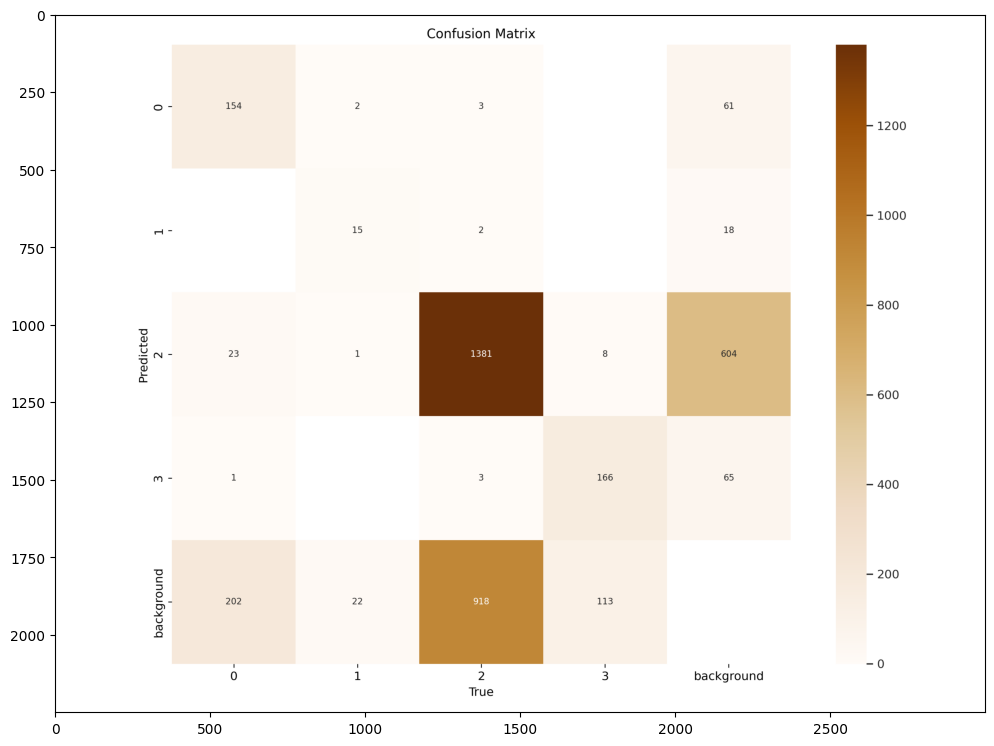

In [69]:
m = '/content/runs/segment/train3/confusion_matrix.png'
img = cv2.imread(m)
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.show()

In [63]:
r = pd.read_csv('/content/runs/segment/train3/results.csv')
r.head()

,epoch,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(M),metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.9524,3.0027,2.2835,1.3099,0.52371,0.30083,0.23553,0.10619,0.48050,0.23657,0.17549,0.06369,1.8298,2.8777,2.0503,1.2705,0.000415,0.000415,0.000415
1,2,1.9272,2.8648,1.8945,1.3100,0.46547,0.24854,0.19774,0.08723,0.41535,0.21277,0.15832,0.05821,1.8103,2.8980,2.0190,1.2413,0.000805,0.000805,0.000805
2,3,1.8898,2.8047,1.8499,1.2809,0.55782,0.27953,0.27067,0.12273,0.55791,0.23975,0.22156,0.08155,1.8042,2.8239,1.7557,1.2581,0.001166,0.001166,0.001166
3,4,1.8493,2.7188,1.7807,1.2638,0.52310,0.31212,0.28619,0.12898,0.29767,0.23986,0.22318,0.07982,1.7740,2.6721,1.8974,1.2483,0.001126,0.001126,0.001126
4,5,1.8055,2.7115,1.7452,1.2406,0.40262,0.34851,0.31222,0.14707,0.35284,0.30159,0.24766,0.09349,1.7111,2.6611,1.6760,1.1994,0.001126,0.001126,0.001126


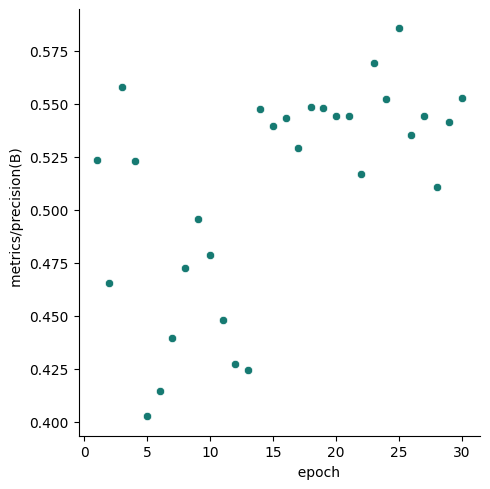

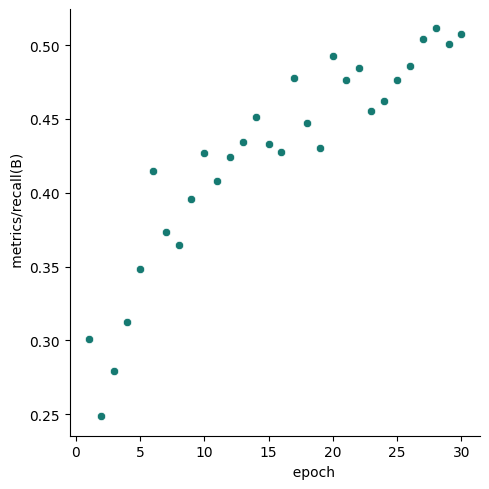

In [80]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1, 1), edgecolor = (0.0, 0.0, 0.0, 0.0))
fig.suptitle("Precision and Recal Rise though Traing")
sns.relplot(data=r, x=r.iloc[:, 0], y=r.iloc[:, 5])
sns.relplot(data=r, x=r.iloc[:, 0], y=r.iloc[:, 6])